<h1 align = "center"><b> AutoARIMA </b></h1>

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats

import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

In [33]:
tabela_vendas = pd.read_csv('../Demanda Diária.csv', index_col = 0, parse_dates = ['data'])
tabela_vendas = tabela_vendas.loc[tabela_vendas['loja'] == 1]
tabela_vendas = tabela_vendas.loc[tabela_vendas['produto'] == 1]
tabela_vendas = tabela_vendas.drop(['loja', 'produto'], axis = 1)

série_vendas = pd.Series(tabela_vendas['itens_vendidos'], index = tabela_vendas.index)
série_vendas = série_vendas.asfreq('D')

In [34]:
def Transformar_Série(série):
	série_transformada, lambda_encontrado = stats.boxcox(série)
	série_transformada = pd.Series(série_transformada, index = série.index)
	print(f'Lambda encontrado: {lambda_encontrado}')

	série_transformada = série_transformada.diff().dropna()
	return série_transformada, lambda_encontrado

série_transformada, lambda_encontrado = Transformar_Série(série_vendas)

Lambda encontrado: 0.576185039143375


In [35]:
série_treino = série_transformada.iloc[:-31]
série_teste = série_transformada.iloc[-31:]

<h2 align = "center"><b> Criando o Modelo </b></h2>

In [36]:
from pmdarima import auto_arima
modelo_AutoARIMA = auto_arima(série_treino, trace = True, stepwise = True, seasonal = True, stationary = True, m = 7)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[7] intercept   : AIC=inf, Time=9.52 sec
 ARIMA(0,0,0)(0,0,0)[7] intercept   : AIC=7575.045, Time=0.06 sec
 ARIMA(1,0,0)(1,0,0)[7] intercept   : AIC=7047.593, Time=0.54 sec
 ARIMA(0,0,1)(0,0,1)[7] intercept   : AIC=6504.436, Time=1.02 sec
 ARIMA(0,0,0)(0,0,0)[7]             : AIC=7573.045, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[7] intercept   : AIC=6611.624, Time=0.43 sec
 ARIMA(0,0,1)(1,0,1)[7] intercept   : AIC=inf, Time=5.89 sec
 ARIMA(0,0,1)(0,0,2)[7] intercept   : AIC=6436.165, Time=2.42 sec
 ARIMA(0,0,1)(1,0,2)[7] intercept   : AIC=inf, Time=8.12 sec
 ARIMA(0,0,0)(0,0,2)[7] intercept   : AIC=7418.483, Time=1.36 sec
 ARIMA(1,0,1)(0,0,2)[7] intercept   : AIC=6427.902, Time=3.63 sec
 ARIMA(1,0,1)(0,0,1)[7] intercept   : AIC=6496.602, Time=3.25 sec
 ARIMA(1,0,1)(1,0,2)[7] intercept   : AIC=6187.119, Time=11.79 sec
 ARIMA(1,0,1)(1,0,1)[7] intercept   : AIC=inf, Time=7.15 sec
 ARIMA(1,0,1)(2,0,2)[7] intercept   : AIC=6157.734, 

In [37]:
resultado_AutoARIMA = modelo_AutoARIMA.fit(série_treino) # ARIMA(1,0,1)(2,0,2)[7]
print(resultado_AutoARIMA.summary())

                                       SARIMAX Results                                        
Dep. Variable:                                      y   No. Observations:                 1794
Model:             SARIMAX(1, 0, 1)x(2, 0, [1, 2], 7)   Log Likelihood               -3070.867
Date:                                Mon, 15 Jan 2024   AIC                           6157.734
Time:                                        23:25:52   BIC                           6201.672
Sample:                                    01-02-2013   HQIC                          6173.956
                                         - 11-30-2017                                         
Covariance Type:                                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0003      0.000     -0.778      0.436      -0.001       0.000
ar.

<h2 align = "center"><b> Análise de Resíduos </b></h2>

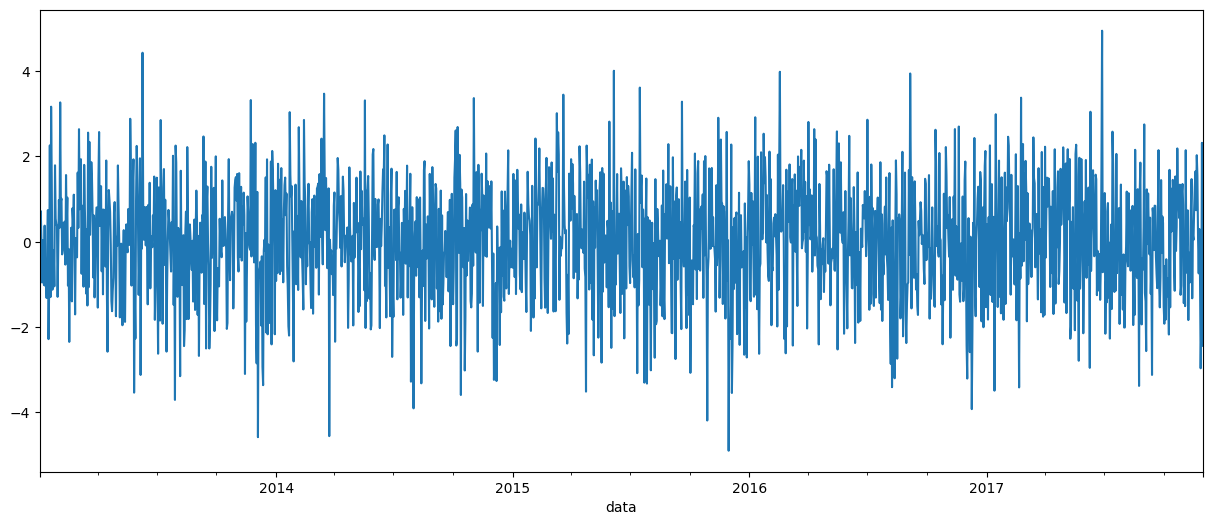

In [62]:
resíduo = resultado_AutoARIMA.resid() # Obtendo os resíduos
resíduo.plot() # Plotando o resíduo
plt.show()

### `Normalidade:`

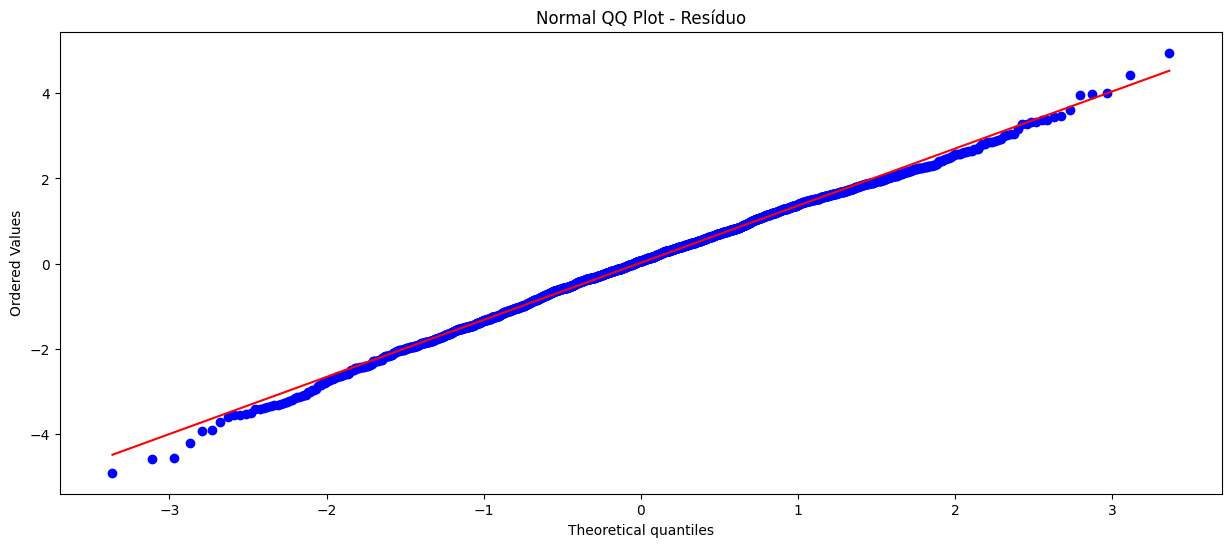

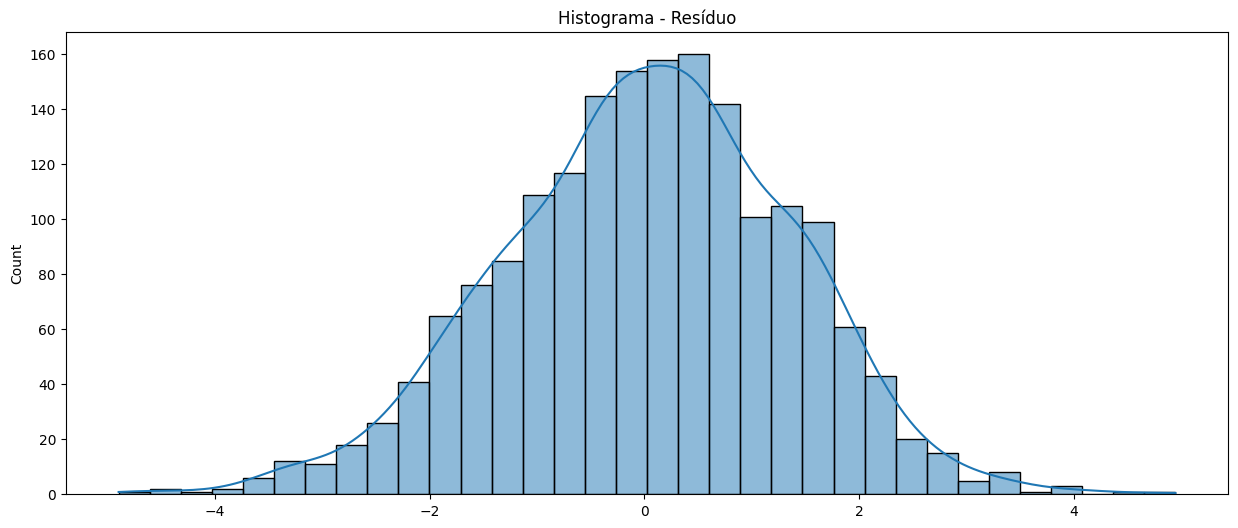

In [39]:
def visualizar_normalidade(série, nome_série = 'Série'):
    stats.probplot(série, dist = 'norm', plot = plt)
    plt.title(f'Normal QQ Plot - {nome_série}') 
    plt.show()

    sns.histplot(série, kde = True)
    plt.title(f'Histograma - {nome_série}')
    plt.show()

visualizar_normalidade(resíduo, 'Resíduo')

In [40]:
def teste_shapiro(série):
    e, p = stats.shapiro(série)
    print(f'Estatística de Teste = {e}')
    print(f'p-valor = {p}')
    print(f'Resultado: {"Não temos evidências para rejeitar a hipótese nula. Então segundo o teste de Shapiro-Wilk, a série provavelmente possui distribuição Normal" if (p > 0.05) else "Temos evidências para rejeitar a hipótese nula. Então segundo o teste de Shapiro-Wilk, a série provavelmente não possui distribuição Normal"}')

teste_shapiro(resíduo)

Estatística de Teste = 0.9977275729179382
p-valor = 0.01187205221503973
Resultado: Temos evidências para rejeitar a hipótese nula. Então segundo o teste de Shapiro-Wilk, a série provavelmente não possui distribuição Normal


&emsp;&emsp; O teste de normalidade de Shapiro-Wilk nos diz que o provavelmente os resíduos não possuem uma distribuição normal, mas olhando o p-valor e os graficos é possível observar que se aproximam bastante de uma distribuição normal. Vamos então assumir que o modelo foi aprovado neste teste.

### `Autocorrelação:`

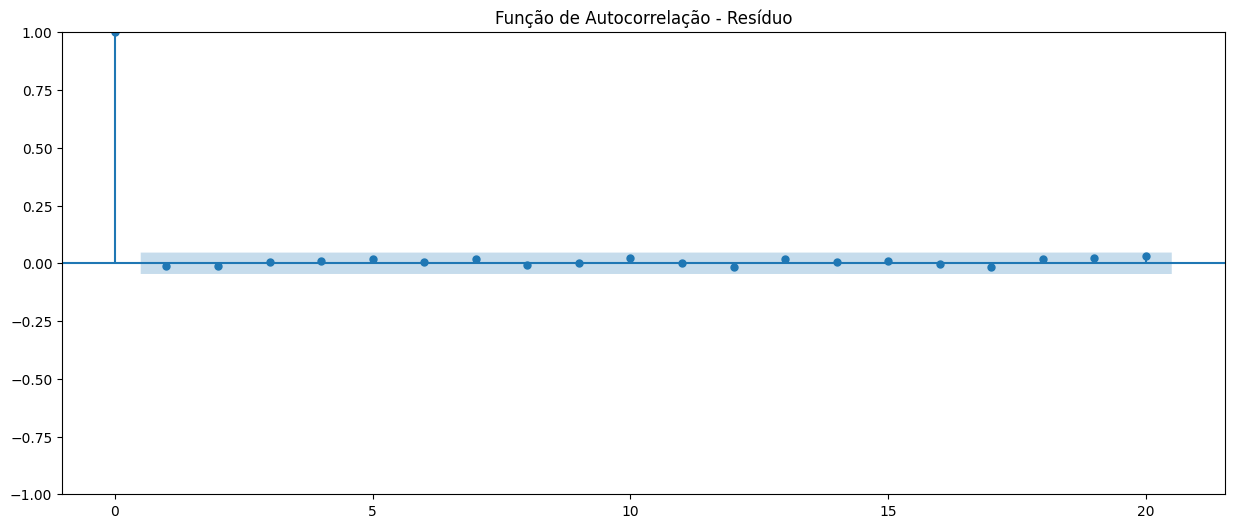

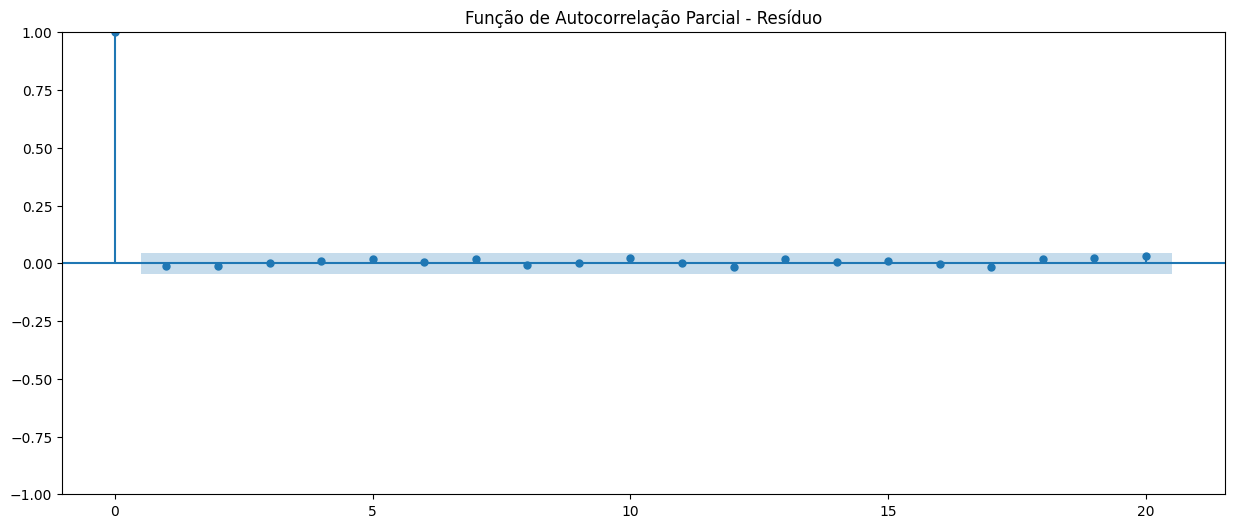

In [41]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
def visualizar_autocorrelação(série, nome_série = 'Série'):
    plot_acf(série, lags = 20)
    plt.title(f'Função de Autocorrelação - {nome_série}')
    plt.show()

    plot_pacf(série, lags = 20)
    plt.title(f'Função de Autocorrelação Parcial - {nome_série}')
    plt.show()

visualizar_autocorrelação(resíduo, 'Resíduo')

&emsp;&emsp; Os gráficos apontam que os resíduos não possuem autocorrelação, o que é um ótimo sinal.

<h2 align = "center"><b> Previsão </b></h2>

In [85]:
previsão = resultado_AutoARIMA.predict(n_periods = 31) # Previsão para os próximo mês

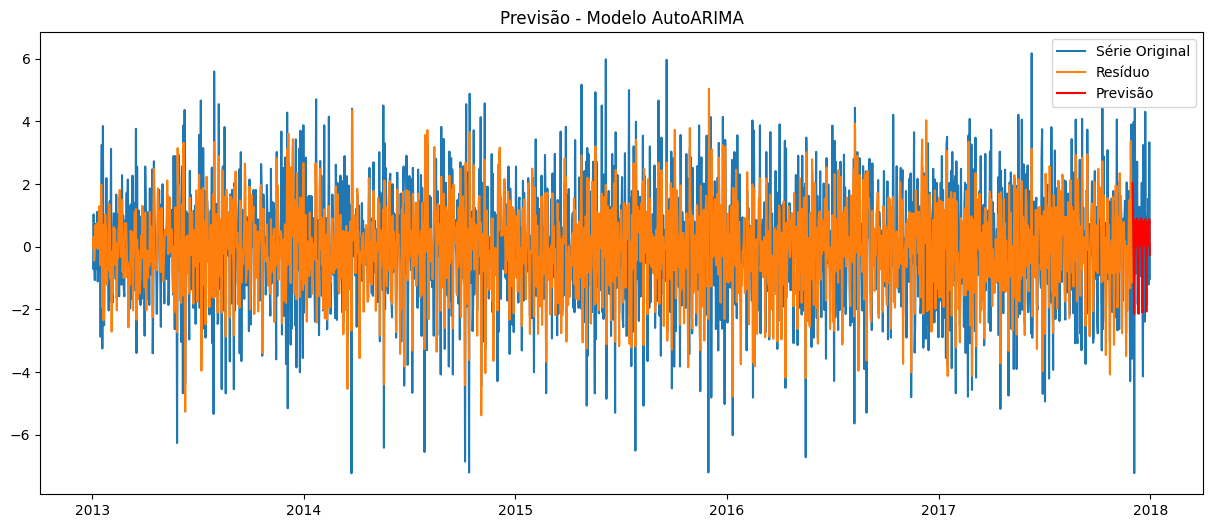

In [64]:
plt.plot(série_transformada, label = 'Série Original')
plt.plot(série_transformada - resíduo, label = 'Resíduo')
plt.plot(previsão, label = 'Previsão', color = 'red')
plt.title('Previsão - Modelo AutoARIMA')
plt.legend(loc = 'best')
plt.show()

<h2 align = "center"><b> Conclusão </b></h2>

In [86]:
def Inverter_Transformação(série_transformada, lambda_encontrado, valor_inicial):
    série_invertida = [stats.boxcox(valor_inicial, lambda_encontrado)]
    for i in range(0, len(série_transformada)):
        série_invertida.append(série_invertida[i] + série_transformada[i])
        if (i == 3): display(série_invertida)
    série_invertida = pd.Series(série_invertida[1:], index = série_transformada.index).dropna()

    if lambda_encontrado == 0: return np.exp(série_invertida)
    else: return (série_invertida * lambda_encontrado + 1) ** (1 / lambda_encontrado)

In [ ]:
resultado = Inverter_Transformação(previsão, lambda_encontrado, série_vendas.iloc[-32])

In [98]:
resultado = pd.DataFrame({'Previsão': resultado, 'Valor Real': série_vendas.iloc[-31:]})
print(resultado)

             Previsão  Valor Real
2017-12-01  21.976535          19
2017-12-02  25.963313          16
2017-12-03  24.829842          31
2017-12-04  17.041296           7
2017-12-05  19.950590          20
2017-12-06  19.948458          17
2017-12-07  21.647763          18
2017-12-08  22.213948          17
2017-12-09  25.676535          27
2017-12-10  24.596830          20
2017-12-11  16.930856          20
2017-12-12  19.686548          13
2017-12-13  19.838534          17
2017-12-14  21.389798          14
2017-12-15  22.044282          16
2017-12-16  25.518433          15
2017-12-17  24.408387          22
2017-12-18  16.871028          19
2017-12-19  19.672265           7
2017-12-20  19.690185          16
2017-12-21  21.316318          12
2017-12-22  21.875950           6
2017-12-23  25.229888          18
2017-12-24  24.179171          19
2017-12-25  16.763302          13
2017-12-26  19.442520          16
2017-12-27  19.570462          14
2017-12-28  21.083418          19
2017-12-29  21

In [89]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

print('RMSE: ', mean_squared_error(resultado['Valor Real'], resultado['Previsão'], squared = False))
print('MAE: ', mean_absolute_error(resultado['Valor Real'], resultado['Previsão']))

RMSE:  6.467341012744788
MAE:  5.3701466006061045
